## Тема “Анализ тональности” 
#### Задание
В качестве заготовки для задания прогоним часть 2ого домашнего задания. Нам необходимо получить разреженные матрицы, используя CountVectorizer, TfidfVectorizer для 'tweet_stemmed' и 'tweet_lemmatized' столбцов (4 матрицы).

Задание 1.
Построим модель LogisticRegression, используя Bag-of-Words признаки для столбца combine_df['tweet_stemmed']. 
- Поделим Bag-of-Words признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].

Задание 2.
Построим модель LogisticRegression, используя TF-IDF признаки для столбца combine_df['tweet_stemmed']. 
- Поделим TF-IDF признаки на train, test (train заканчивается на 31962 строке combine_df)
- Ответами является столбец train_df['label']
- Рассчитаем predict_proba, приведем prediction в в бинарный вид: если предсказание >= 0.3 то 1, иначе 0, тип заменим на int
- Рассчитаем f1_score 

Повторим аналогично для столбца combine_df['tweet_lemmatized'].

Задание 3.
Выведите результаты f1-score всех моделей, сделайте вывод.

Задание 4.
Теперь перейдем к визуализации. Посмотрим, какие слова являются наиболее популярные в датасете с помощью облака слов (WordCloud).
Облако слов - это визуализация, в которой наиболее частые слова большого размера, а менее частые слова меньшего размера.
- объединим слова в одну строку
- создадим словарь частот слов с помощью collections.Counter
- нарисуем облако слов с частотами слов с помощью WordCloud.generate_from_frequencies()
- используем nltk.corpus.stopwords как параметр stopwords, чтобы убрать "мусорные" частотные слова

Задание 5.
Теперь отобразим облако слов для отзывов, не содержащих токсичных комментариев (combine_df['label'] == 0). 

Задание 6.
Теперь отобразим облако слов для отзывов, содержащих токсичные комментарии (combine_df['label'] == 1). 


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
if 0:
    !pip install -U wordcloud

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

tqdm.pandas()

PREP_DATA = '../data/prep_tweets.pkl'

In [4]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import collections

#### Загрузим подготовленный датасет твиттов

In [5]:
df_prep = pd.read_pickle(PREP_DATA)
df_prep.head()

,id,label,tweet,clean_tweet,tweet_token,tweet_token_filtered,tweet_stemmed,tweet_lemmatized
0,1,0.0,@user when a father is dysfunctional and is s...,when father is dysfunctional and is so selfish...,"[when, father, is, dysfunctional, and, is, so,...","[father, dysfunctional, selfish, drags, kids, ...","[father, dysfunct, selfish, drag, kid, dysfunc...","[father, dysfunctional, selfish, drag, kid, dy..."
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit cannot use cause they d...,"[thanks, for, lyft, credit, can, not, use, cau...","[thanks, lyft, credit, use, cause, offer, whee...","[thank, lyft, credit, use, caus, offer, wheelc...","[thank, lyft, credit, use, cause, offer, wheel..."
2,3,0.0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, majesty]","[bihday, majesti]","[bihday, majesty]"
3,4,0.0,#model i love u take with u all the time in ...,model love you take with you all the time in ur,"[model, love, you, take, with, you, all, the, ...","[model, love, take, time, ur]","[model, love, take, time, ur]","[model, love, take, time, ur]"
4,5,0.0,factsguide: society now #motivation,factsguide society now motivation,"[factsguide, society, now, motivation]","[factsguide, society, motivation]","[factsguid, societi, motiv]","[factsguide, society, motivation]"


### Подготовка и разбивка датасета

In [6]:
TRAIN_INDEX = 31962
VAl_PART = 0.3

# получим тест и трайн без исопользования индекса - по наличию label
df_train = df_prep.loc[df_prep.label.notna(), ['tweet_stemmed', 'tweet_lemmatized', 'label']]
df_train.shape[0]

31962

In [7]:
# нужна стратифицированная выборка
df_train.label.value_counts(normalize=True)

0.0    0.929854
1.0    0.070146
Name: label, dtype: float64

In [8]:
X = df_train.drop('label', axis=1)
Y = df_train.label

X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=VAl_PART,
    random_state=42,
    shuffle=True,
    stratify=Y
)

### Векторизация

In [9]:
def _make_bag_of_words(vectorizer: object, 
                       data: pd.Series) -> pd.DataFrame:
    """
    _Промежуточная функция для получения bag_of_words.

    Parameters
    ----------
    data: pd.Series
        Серия со списками токенов
        
    vectorizer: object
        Объект векторайзера Bag-of-words.
            
    Returns
    -------
    pd.DataFrame
        Разреженная матрица токенизиорованных эмбеддингов для использования в моделях.

    """
    
    bag_of_words = vectorizer.fit_transform(data.apply(' '.join))
    
    # Отобразим Bag-of-Words модель как DataFrame
    feature_names = vectorizer.get_feature_names()
    return pd.DataFrame(bag_of_words.toarray(), columns = feature_names).copy()

In [10]:
def make_embedding(data: pd.Series,
                  vectorizer: callable,
                  parameters: dict = {'max_df': 0.9,
                                      'max_features': 1000,
                                      'stop_words': 'english'}) -> pd.DataFrame:
    
    model = vectorizer(**parameters)
    return _make_bag_of_words(model, data)

In [11]:
X_train_stem_CV = make_embedding(data=X_train['tweet_stemmed'], vectorizer=CountVectorizer)
X_test_stem_CV = make_embedding(data=X_test['tweet_stemmed'], vectorizer=CountVectorizer)

X_train_lemm_CV = make_embedding(data=X_train['tweet_lemmatized'], vectorizer=CountVectorizer)
X_test_lemm_CV = make_embedding(data=X_test['tweet_lemmatized'], vectorizer=CountVectorizer)

In [12]:
X_train_stem_TF = make_embedding(data=X_train['tweet_stemmed'], vectorizer=TfidfVectorizer)
X_test_stem_TF = make_embedding(data=X_test['tweet_stemmed'], vectorizer=TfidfVectorizer)

X_train_lemm_TF = make_embedding(data=X_train['tweet_lemmatized'], vectorizer=TfidfVectorizer)
X_test_lemm_TF = make_embedding(data=X_test['tweet_lemmatized'], vectorizer=TfidfVectorizer)

# Тренируем модели и вычисляем скор

In [13]:
# чуть поправил функцию расчета скора
def eval_model(model: object,
               X_train: pd.DataFrame,
               y_train: pd.Series,
               X_test: pd.DataFrame,
               y_test: pd.Series,
               eval_metric: callable = f1_score) -> float:
    
    """
    Оценка качеcтва модели.

    Parameters
    ----------
    model: callabe
        Инициализированная модель для обучения.
    
    X_train, X_test: pandas.DataFrame
    
    Разреженные матрицы токенизированных эмбеддингов.
    Получение из сплитов в функции get_embedding().
    
    y_train, y_test:
    
    Размеченные сплиты меток классов.
    
    eval_metric: callable
        Метрика качества.
        Опциональный параметр, по умолчанию используется f1_score.

    Returns
    -------
    score: float
        Расчетное качество по заданной метрике
    """
    
    model.fit(X_train, y_train)
    pred_prob = model.predict_proba(X_test)
    y_pred = np.where(pred_prob[:,1]>0.3, 1, 0)
    score = eval_metric(y_test, y_pred)
    
    return score

In [14]:
%%time
# рассчитываем результаты классификатора
model = LogisticRegression(random_state=42, n_jobs=-1)

F1_CV_S = eval_model(model, X_train_stem_CV, y_train, X_test_stem_CV, y_test)
F1_CV_L = eval_model(model, X_train_lemm_CV, y_train, X_test_lemm_CV, y_test)

F1_TF_S = eval_model(model, X_train_stem_TF, y_train, X_test_stem_TF, y_test)
F1_TF_L = eval_model(model, X_train_lemm_TF, y_train, X_test_lemm_TF, y_test)

CPU times: user 1.22 s, sys: 520 ms, total: 1.74 s
Wall time: 10.2 s


In [23]:
# вывод результатов
print(f'F1 для Count Vect Stem = {F1_CV_S}')
print(f'F1 для Count Vect Lemm = {F1_CV_L}')

print(f'F1 для TFIDF Stem = {F1_TF_S}')
print(f'F1 для TFIDF Lemm = {F1_TF_L}')

F1 для Count Vect Stem = 0.18477331052181353
F1 для Count Vect Lemm = 0.07882676443629698
F1 для TFIDF Stem = 0.18828451882845187
F1 для TFIDF Lemm = 0.05695509309967141


#### В данном случае лучше отработал TFIDF Stemmed

## Частотная Визуализация

In [35]:
from nltk.corpus import stopwords
#from nltk.stem.wordnet import WordNetLemmatizer

stop_words = set(stopwords.words("english"))

#### Для всего датасета

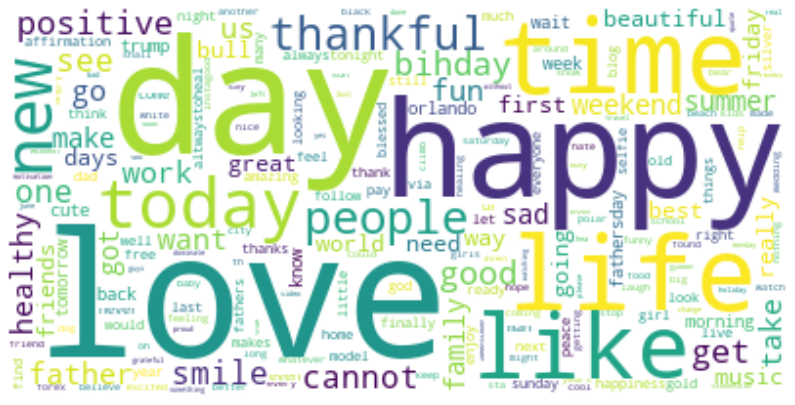

In [40]:
words = []
for line in df_prep['clean_tweet']: 
    line_words = [word for word in line.split() if word not in stop_words]
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='white',
 max_words=10000,
 stopwords=stop_words
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(14,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Для **Положительных** отзывов

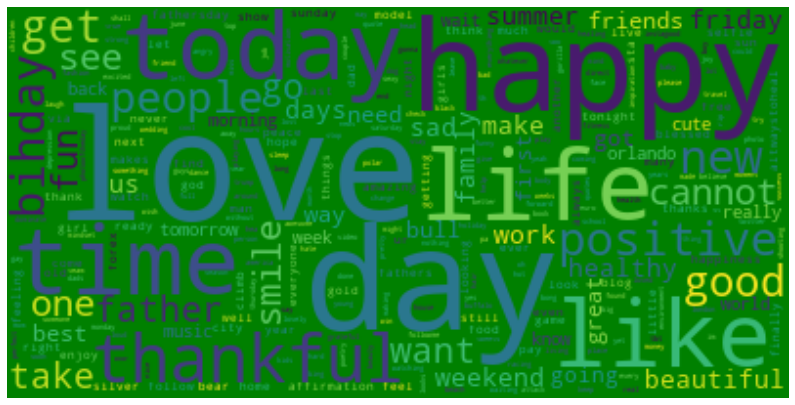

In [41]:
words = []
for line in df_prep.loc[df_prep['label'] == 0, 'clean_tweet']:
    line_words = [word for word in line.split() if word not in stop_words]
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='green',
 max_words=10000,
 stopwords=stop_words
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(14,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Для **Отрицательных** отзывов

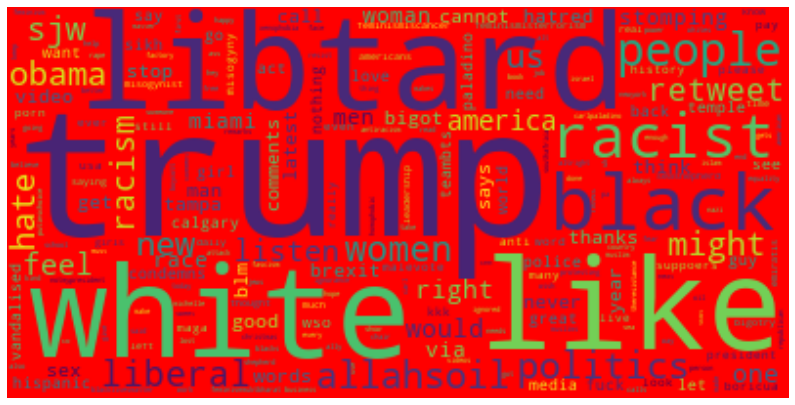

In [42]:
words = []
for line in df_prep.loc[df_prep['label'] == 1, 'clean_tweet']:
    line_words = [word for word in line.split() if word not in stop_words]
    words.extend(line_words)

wordfreq = collections.Counter(words)
wordcloud = WordCloud(
 background_color='red',
 max_words=10000,
 stopwords=stop_words
 ).generate_from_frequencies(wordfreq)
plt.figure(figsize=(14,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()